In [1]:
! pip install pymdptoolbox

In [ ]:

import numpy as np
import pandas as pd

from Predictor import Predictor
import MDP
from constants import REGION_LABEL, REGION_CODE_INVERSE, POLICY_MAP

In [ ]:
%load_ext autoreload
%autoreload 2

## Load Data

In [ ]:
data = pd.read_csv('./data/region_monthly_electricity_consumption_clean.csv', index_col=0)


In [ ]:
data.head()

,region,2005-01-01,2005-02-01,2005-03-01,2005-04-01,2005-05-01,2005-06-01,2005-07-01,2005-08-01,2005-09-01,...,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01
0,Overall,418.1,408.3,446.9,496.2,496.8,519.7,497.7,489.3,477.7,...,449.7,463.0,457.3,415.9,384.1,394.9,423.7,491.0,482.9,464.1
1,Central Region,485.4,459.0,500.2,566.4,573.3,590.1,568.3,551.7,539.5,...,505.4,523.1,527.6,481.4,442.7,436.7,478.9,553.5,558.8,524.8
2,Bishan,433.6,420.5,479.2,513.5,516.3,545.0,522.6,507.7,505.8,...,463.0,495.7,471.5,429.1,379.6,416.1,471.4,498.0,485.4,489.9
3,Bukit Merah,320.0,264.9,292.4,358.7,354.2,350.0,358.4,337.8,343.2,...,368.9,364.2,384.9,346.4,341.6,301.1,330.2,389.9,421.9,380.2
4,Bukit Timah,963.4,930.5,1035.2,1149.5,1132.3,1173.7,1101.2,1051.2,1039.0,...,911.5,951.0,916.9,834.9,797.2,760.7,876.8,1012.1,938.6,856.5


In [ ]:
data_trunc = data.iloc[:, :-6] # use last 6 months for evaluation

## Train Time Series Predictor

In [ ]:
predictor = Predictor(data_trunc)

01:51:06 - cmdstanpy - INFO - Chain [1] start processing
01:51:07 - cmdstanpy - INFO - Chain [1] done processing
01:51:07 - cmdstanpy - INFO - Chain [1] start processing
01:51:07 - cmdstanpy - INFO - Chain [1] done processing
01:51:07 - cmdstanpy - INFO - Chain [1] start processing
01:51:07 - cmdstanpy - INFO - Chain [1] done processing
01:51:07 - cmdstanpy - INFO - Chain [1] start processing
01:51:07 - cmdstanpy - INFO - Chain [1] done processing
01:51:07 - cmdstanpy - INFO - Chain [1] start processing
01:51:07 - cmdstanpy - INFO - Chain [1] done processing
01:51:07 - cmdstanpy - INFO - Chain [1] start processing
01:51:07 - cmdstanpy - INFO - Chain [1] done processing
01:51:07 - cmdstanpy - INFO - Chain [1] start processing
01:51:07 - cmdstanpy - INFO - Chain [1] done processing
01:51:08 - cmdstanpy - INFO - Chain [1] start processing
01:51:08 - cmdstanpy - INFO - Chain [1] done processing
01:51:08 - cmdstanpy - INFO - Chain [1] start processing
01:51:08 - cmdstanpy - INFO - Chain [1]

In [ ]:
predictor.predict("Geylang", "2024-01")

Geylang 2024-01 -> 367.2690792338605 [np.float64(435.79999999999995), np.float64(477.5666666666666)]
Primary region type: residential -> State: 0


(0, np.float64(367.2690792338605))

## Run MDP

In [ ]:
P = MDP.make_transition_prob(data_trunc)

In [ ]:
R_holiday = MDP.make_rewards("holiday")
R_common = MDP.make_rewards("common")

In [ ]:
mdp_common = MDP.MDP(P, R_common, 0.6)
mdp_holiday = MDP.MDP(P, R_holiday, 0.6)

In [ ]:
policy_holiday = mdp_holiday.get_policy()
policy_common = mdp_common.get_policy()

In [ ]:
policy_holiday

(0, 0, 0, 1, 1, 1, 0, 2, 2, 2, 2, 2)

In [ ]:
policy_common

(0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2)

## Evaluate

In [ ]:
overall_consumption_df = pd.DataFrame(columns=['original', 'mdp-based'])
overall_consumption_diff = 0
time_periods = ["2024-01","2024-02","2024-03","2024-04","2024-05","2024-06"]
for time_period in time_periods:
    time_period_diff = 0
    mdp_total_consumption = 0
    for region in REGION_LABEL:
        
        code, y_pred = predictor.predict(region, time_period)
        region_type = REGION_CODE_INVERSE[code // 3]
        action = POLICY_MAP[policy_common[code]]

        y = float(data.loc[data['region']==region,time_period+"-01"].values[0])
        diff = y_pred - y
        # print(f"{region} - {region_type}: {action}")

        if action == POLICY_MAP[0]: # KEEP AS IS
            if not np.isnan(y):
                mdp_total_consumption += y
        else:
            # print(f"consumption difference: {diff}")
            if not np.isnan(diff):
                overall_consumption_diff += diff
                time_period_diff += diff
                mdp_total_consumption += y_pred
                # print(f"Overall consumption difference: {overall_consumption_diff}")

    overall_consumption_df.loc[time_period, 'original'] = data.loc[:, time_period+"-01"].apply(pd.to_numeric, errors='coerce').sum()
    overall_consumption_df.loc[time_period, 'mdp-based'] = mdp_total_consumption

overall_consumption_diff

Central Region 2024-01 -> 455.27993007593113 [np.float64(505.0666666666666), np.float64(551.5)]
Primary region type: commercial -> State: 3
East Region 2024-01 -> 398.619719528345 [np.float64(450.1666666666667), np.float64(494.69999999999993)]
Primary region type: residential -> State: 0
North East Region 2024-01 -> 370.14663812478597 [np.float64(415.1333333333333), np.float64(449.73333333333335)]
Primary region type: residential -> State: 0
North Region 2024-01 -> 361.6302748202302 [np.float64(394.76666666666665), np.float64(424.4)]
Primary region type: residential -> State: 0
West Region 2024-01 -> 351.8436612886147 [np.float64(392.6), np.float64(425.19999999999993)]
Primary region type: residential -> State: 0
Bishan 2024-01 -> 395.67876310536 [np.float64(457.1333333333333), np.float64(499.59999999999997)]
Primary region type: residential -> State: 0
Bukit Merah 2024-01 -> 344.96767970416164 [np.float64(339.23333333333335), np.float64(366.96666666666664)]
Primary region type: reside

np.float64(-94.07163454966343)

In [ ]:
overall_consumption_df


overall_consumption_df['percentage_diff'] = ((overall_consumption_df['mdp-based'] - overall_consumption_df['original']) / overall_consumption_df['original']) * 100

overall_consumption_df


,original,mdp-based,percentage_diff
2024-01,23353.4,23218.667318,-0.57693
2024-02,22900.2,22835.900041,-0.280783
2024-03,24899.2,24421.809191,-1.917294
2024-04,29434.5,28132.939424,-4.421888
2024-05,31962.0,30628.155022,-4.173221
2024-06,27531.6,28108.657369,2.095982


In [ ]:
perc_change = (overall_consumption_df['mdp-based'].sum() - overall_consumption_df['original'].sum()) / overall_consumption_df['original'].sum()
perc_change * 100

np.float64(-1.7083684777819768)

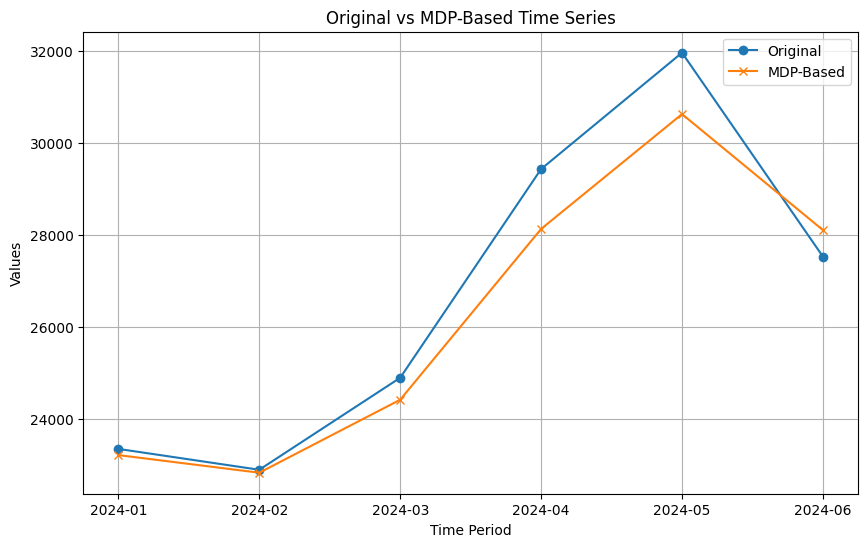

In [ ]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_periods, overall_consumption_df['original'], label='Original', marker='o')
plt.plot(time_periods, overall_consumption_df['mdp-based'], label='MDP-Based', marker='x')

plt.title('Original vs MDP-Based Time Series')
plt.xlabel('Time Period')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.savefig('output/MDP-based Comparison.png')
plt.show()
